# Wrangling with Restaurant Reviews

The goal of this project was to examine the values of Toronto restaurant diners. I identified latent topics and cluster Toronto restaurant Yelp reviews using sentiment analysis, dimensionality reduction, and unsupervised clustering.

In [1]:
import json
import pandas as pd
import numpy as np
import scipy as sp
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
from scipy.misc import imread

import nltk
import spacy
import re
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.manifold import TSNE

%matplotlib inline

/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [2]:
nlp = spacy.load('en')

In [3]:
sns.set_style("whitegrid")

### Load and subset data for Toronto restaurants

In [2]:
# load review data
df_reviews = pd.read_json('./yelp_dataset_challenge_round9/yelp_academic_dataset_review.json',lines=True)
df_reviews.shape

(4153150, 10)

In [30]:
df_reviews.columns

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'type', 'useful', 'user_id'],
      dtype='object')

In [31]:
# load business information data
df_business = pd.read_json('/home/aileen/yelp/yelp_dataset_challenge_round9/yelp_academic_dataset_business.json',lines=True)

In [32]:
df_business.shape

(144072, 16)

In [33]:
# merge the review data frame and the business information data frame
df = df_business.merge(df_reviews, how="right", left_on="business_id", right_on="business_id")
df.shape

(4153150, 25)

In [34]:
df.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'neighborhood',
       'postal_code', 'review_count', 'stars_x', 'state', 'type_x', 'cool',
       'date', 'funny', 'review_id', 'stars_y', 'text', 'type_y', 'useful',
       'user_id'],
      dtype='object')

In [38]:
# subset only Toronto buisnesses
to_all = df[df.city=="Toronto"]
to_all.shape

(349696, 25)

In [41]:
# identify restaurant businesses
restaurant = []

for index, value in enumerate(to_all.categories):
    try:
        restaurant.append("Restaurants" in value)
    except:
        restaurant.append(np.nan)
        
to_all['restaurant'] = restaurant
to = to_all[to_all.restaurant==True].reset_index()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [43]:
# pickle for future use
pickle.dump(to, open("to.pkl", "wb"))

### Explore data

In [4]:
# load pickled Toronto resturants data frame
to = pickle.load(open("to.pkl", "rb"))

In [5]:
print(to.shape)

(245127, 27)


In [6]:
print("number of unique restaurants: {}".format(len(to.business_id.unique())))
print("number of unique users: {}".format(len(to.user_id.unique())))

number of unique restaurants: 6347
number of unique users: 58355


In [7]:
to.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245127 entries, 0 to 245126
Data columns (total 27 columns):
index           245127 non-null int64
address         245127 non-null object
attributes      244689 non-null object
business_id     245127 non-null object
categories      245127 non-null object
city            245127 non-null object
hours           216849 non-null object
is_open         245127 non-null int64
latitude        245127 non-null float64
longitude       245127 non-null float64
name            245127 non-null object
neighborhood    245127 non-null object
postal_code     245127 non-null object
review_count    245127 non-null int64
stars_x         245127 non-null float64
state           245127 non-null object
type_x          245127 non-null object
cool            245127 non-null int64
date            245127 non-null datetime64[ns]
funny           245127 non-null int64
review_id       245127 non-null object
stars_y         245127 non-null int64
text            245127 non

In [8]:
to.sample(5)

,index,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,...,cool,date,funny,review_id,stars_y,text,type_y,useful,user_id,restaurant
185048,3133566,484 Dundas St W,"[Alcohol: beer_and_wine, Ambience: {'romantic'...",2Q89PhkcyT9uZnQORmqMKg,"[Restaurants, Chinese]",Toronto,"[Monday 8:0-2:0, Tuesday 8:0-2:0, Wednesday 8:...",1,43.653225,-79.397247,...,0,2016-09-21,0,BhYuiXG1mOYXNARK9wUXUA,4,Came here at midnight and it was pretty busy c...,review,0,pFCb-1j6oI3TDjr26h2cJQ,True
164988,2807560,20 Charles Street E,"[Alcohol: beer_and_wine, Ambience: {'romantic'...",RvYjKtzdIPA2VBUpJJbzCw,"[Restaurants, Japanese]",Toronto,"[Monday 17:30-21:30, Tuesday 11:30-14:30, Tues...",1,43.669243,-79.385329,...,0,2014-10-21,0,jyjMRk9Fx_tUWkJ7yhcrAw,1,DO NOT GO!!! THE WORST JAPANESE RESTAURANT EVE...,review,2,CSFfvjjGfEPL5oEoks7ESA,True
242403,4112775,689 Bloor St W,"[Alcohol: beer_and_wine, Ambience: {'romantic'...",o6Yor6ofIw2TqM3mN28Kzg,"[Latin American, Mexican, Restaurants]",Toronto,"[Monday 12:0-21:0, Tuesday 12:0-21:0, Wednesda...",1,43.663862,-79.416992,...,0,2015-09-21,0,0MS8sgah3kv6UmZIEW1Zmg,4,The staff here are very friendly and it's a gr...,review,0,VYo65BNT4TpU0_ixcViiKw,True
12240,236218,19 Church Street,"[Alcohol: full_bar, BestNights: {'monday': Fal...",BfE8TnYa_LI1PyNSgs_v_g,"[Bars, Nightlife, Cocktail Bars, Tapas Bars, R...",Toronto,"[Tuesday 17:0-0:0, Wednesday 17:0-0:0, Thursda...",1,43.647989,-79.373396,...,0,2014-05-31,0,65ApPRk89F6fcQlhOyfV6A,4,We stopped in here on our way to dinner. You ...,review,1,1ZTRga13YNWJYn5qX6SxRQ,True
180135,3049457,568 Parliament Street,"[Alcohol: full_bar, Ambience: {'romantic': Fal...",nqTvE7ivdU23oUWdI01tOA,"[Restaurants, Caribbean, Food, Breakfast & Bru...",Toronto,"[Tuesday 11:0-22:0, Wednesday 11:0-22:0, Thurs...",1,43.667423,-79.369456,...,0,2015-11-18,0,bNZB1EYZbQEkcTTZk6y5MA,5,25 years ago I had my first and only piece of ...,review,0,VZx_Tqu2WPgL5-A4mViyJQ,True


In [10]:
businesses = deepcopy(to[["business_id", "latitude", "longitude", "name", "stars_x", "review_count"]])
business_location = businesses.drop_duplicates()

In [11]:
business_location.shape

(6347, 6)

In [12]:
business_location[["latitude","longitude"]].describe()

,latitude,longitude
count,6347.000000,6347.000000
mean,43.680059,-79.391671
std,0.045743,0.059756
min,43.592411,-79.703390
25%,43.650888,-79.416981
50%,43.663553,-79.393216
75%,43.688668,-79.373740
max,43.876501,-79.137540


In [13]:
# plot the location of all the restaurants using Plotly
import plotly.plotly as py
from plotly.graph_objs import *

# restaurant description
restaurant_desc=["Restaurant: {}".format(name) + "<br>Average {} star rating".format(stars)+ "<br>{} reviews".format(count)
                 for name, stars, count in zip(list(business_location['name']), list(business_location['stars_x']), list(business_location['review_count']))]

data1 = Data([
    Scattermapbox(
        lat=business_location['latitude'],
        lon=business_location['longitude'],
        mode='markers',
        marker=Marker(
            color = 'red',
            size=9,
            opacity=0.4
        ),
        text=restaurant_desc,
        hoverinfo='text+lon+lat'
    )
])

layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        bearing=0,
        # median: 43.663553° N, 79.393216° W
        center=dict(
            lat=43.66,
            lon=-79.39
        ),
        pitch=0,
        zoom=10
    ),
)

fig1 = dict(data=data1, layout=layout)
py.iplot(fig1, filename='Toronto Restaurants Map')

### Clean and format reviews

Before lemmetizing the reviews, I tried to clean the text and keep possible relevant information. Before removing all non-english characters and numbers, I identified when cost or price, and time was specifically mentioned. I also removed the terms "toronto" and "restaurant" because they are common and uninformative.

In [ ]:
# clean reviews
text_clean = []
punctuation = re.compile(r"[!#$%&\'\"()\*\+,-\./:;<=>\?@\[\\\]^_`{\|}~]")

for review in to.text:
    temp = review.lower()
    temp = re.sub(r"\n", " ", temp)
    temp = re.sub(r"\$\d+[\.\d]+", " price ", temp)
    temp = re.sub(r"\d+[\.\d]+\$", " price ", temp)
    temp = re.sub(r"\d+:\d{2}", " time ", temp)
    temp = re.sub(r"toronto", " ", temp)
    temp = re.sub(r"restaurant", " ", temp)
    temp = re.sub(r"[^A-Za-z]+", " ", temp)
    temp = re.sub(punctuation, " ", temp)
    text_clean.append(temp)
    
len(text_clean)

In [10]:
# remove stopwords and apply lemmatization
def remove_stopwords_lemma(review):
    remain = ''
    doc = nlp(review)
    for token in doc:
        if token.is_stop:
            continue
        elif token.is_space:
            continue
        elif len(token)<=1:
            continue
        else:
            remain += token.lemma_ + ' '
    return remain


bag_of_words = []
for review in text_clean:
    bag_of_words.append(remove_stopwords_lemma(review))

len(bag_of_words)

245127

In [14]:
print(to.text[25050])
print(text_clean[25050])
print(bag_of_words[25050])

Their chicken tacos melt in your mouth. The prices are a steal! The rice was a little dry to my liking but everything else was delicious. I wanted to try the empanadas but they were sold out. :(  I will definitely come back for the tacos and order the empanadas.  The food is fresh and their pops are imported from Mexico so the coke tastes a but different (not as carbonated and strong).  The place only has about 6 tables so it's small. I would order take-out if it seems busy.
their chicken tacos melt in your mouth the prices are a steal the rice was a little dry to my liking but everything else was delicious i wanted to try the empanadas but they were sold out i will definitely come back for the tacos and order the empanadas the food is fresh and their pops are imported from mexico so the coke tastes a but different not as carbonated and strong the place only has about tables so it s small i would order take out if it seems busy 
chicken taco melt mouth price steal rice little dry likin

In [15]:
# pickle for future use
pickle.dump(text_clean, open("text_clean.pkl", "wb"))
pickle.dump(bag_of_words, open("bag_of_words.pkl", "wb"))

### Sentiment analysis on reviews

In [16]:
# load picked cleaned reviews
text_clean = pickle.load(open("text_clean.pkl", "rb"))
bag_of_words = pickle.load(open("bag_of_words.pkl", "rb"))

In [66]:
# sentiment analysis (positive, negative, neutral, compound)
pos_nltk = []
neg_nltk = []
neu_nltk = []
compound_nltk = []

# get sentiment scores for each review (original)
sid = SentimentIntensityAnalyzer()
for review in to.text:
    ss = sid.polarity_scores(review)
    pos_nltk.append(ss['pos'])
    neg_nltk.append(ss['neg'])
    neu_nltk.append(ss['neu'])
    compound_nltk.append(ss['compound'])

# add sentiment analysis results to data frame
to['pos_nltk'] = pos_nltk
to['neg_nltk'] = neg_nltk
to['neu_nltk'] = neu_nltk
to['compound_nltk'] = compound_nltk
    
len(pos_nltk)

245127

In [94]:
# calculate a combined postive and negative sentiment score
# generally positive reviews are "+" and generally negative reviews are "-"
to['combined_nltk'] = to['pos_nltk'] - to['neg_nltk']

0.709540128240705

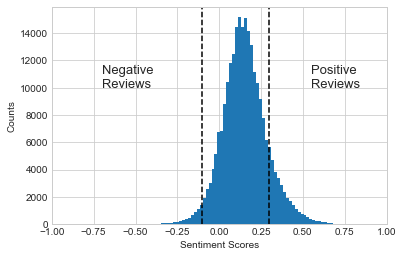

In [15]:
# histogram of sentiment scores with positive and negative review thresholds
plt.hist(to.combined_nltk, bins=100)
plt.axvline(x=-0.1, color="k",linestyle="dashed")
plt.axvline(x=0.3, color="k",linestyle="dashed")

plt.text(0.55, 11000, "Positive", fontsize=13)
plt.text(0.55, 10000, "Reviews", fontsize=13)
plt.text(-0.7, 11000, "Negative", fontsize=13)
plt.text(-0.7, 10000, "Reviews", fontsize=13)
plt.xlim(-1.0,1.0)
plt.xlabel("Sentiment Scores")
plt.ylabel("Counts")

plt.savefig("polarity_histogram.png", dpi=900);

In [95]:
# pickle for future use
pickle.dump(to, open("to_polarity.pkl", "wb"))

In [4]:
# load pickled Toronto restaurants data frame
to = pickle.load(open("to_polarity.pkl", "rb"))

In [17]:
to.text[1000]

"Nice ambiance and good location. Mediocre food and extremely slow service. I was with a party of 6 and it took us just over 3 hours from beginning to end. We weren't eating slowly at all. Thank goodness we skipped appetizers, as I imagine that would have taken another 45 minutes!"

Positive and negative reviews were identified. Positive reviews had sentiment scores > 0.3, and negative reviews had sentiment scores < -0.2. This was to avoid neutral reviews.

In [18]:
# collect positive sentiment reviews together
positive_reviews = [bag_of_words[index] for index,polarity in enumerate(to.combined_nltk) if polarity > 0.3]
len(positive_reviews)

30528

In [35]:
# example of positive review
print("Sentiment score: {}".format(to.combined_nltk[14059]))
print("Review: {}".format(to.text[14059]))

Sentiment score: 0.865
Review: Elegant, comfortable, inspiring. Beautiful and delicious food. Always a smile.


In [20]:
# collect negative sentiment reviews together
negative_reviews = [bag_of_words[index] for index,polarity in enumerate(to.combined_nltk) if polarity < -0.2]
len(negative_reviews)

1531

In [36]:
# example of negative review
print("Sentiment score: {}".format(to.combined_nltk[198798]))
print("Review: {}".format(to.text[198798]))

Sentiment score: -0.711
Review: Terrible food. Flat beer. Bad service. Uncomfortable atmosphere. 
Gross.


Based on visual examination, most of the sentiment scores matched their corresponding review. However, there were a small number of sentiments scores that did not match the review.

In the example below, "damn" was interpreted as a negative word, but in this context it was a positive word.

In [11]:
# problematic sentiment analysis result example
print(to.combined_nltk[203769])
print(to.text[203769])

-0.73
Damn spicy. Damn greasy. Damn cheap. Damn tasty.


In [22]:
# pickle for future use
pickle.dump(positive_reviews, open("positive_reviews.pkl", "wb"))
pickle.dump(negative_reviews, open("negative_reviews.pkl", "wb"))

In [5]:
# load pickled positive and negative reviews
positive_reviews = pickle.load(open("positive_reviews.pkl", "rb"))
negative_reviews = pickle.load(open("negative_reviews.pkl", "rb"))

In [16]:
# examine the sentiment analysis descriptive statistics
to[["combined_nltk", "pos_nltk", "neg_nltk", "neu_nltk", "compound_nltk"]].describe()

,combined_nltk,pos_nltk,neg_nltk,neu_nltk,compound_nltk
count,245127.000000,245127.000000,245127.000000,245127.000000,245127.000000
mean,0.152586,0.194614,0.042028,0.763353,0.707457
std,0.135020,0.106829,0.049761,0.097719,0.494958
min,-0.773000,0.000000,0.000000,0.000000,-0.998500
25%,0.069000,0.121000,0.000000,0.713000,0.739600
50%,0.146000,0.180000,0.029000,0.776000,0.931100
75%,0.230000,0.251000,0.062000,0.829000,0.977300
max,1.000000,1.000000,0.773000,1.000000,0.999800


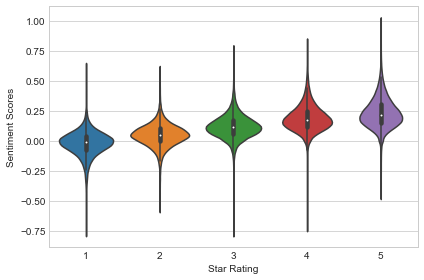

In [39]:
# violin plot of star rating and sentiment scores
sns.violinplot(x=to.stars_y, y=to.combined_nltk)
plt.xlabel("Star Rating")
plt.ylabel("Sentiment Scores")
plt.tight_layout();

plt.savefig("sentiment_rating_violinplot.png", dpi=900);

In general, positive reviews had higher star ratings compared to the negative reviews (i.e., mean and median).

In [91]:
to["positive_negative"] = ['Positive' if polarity > 0.3 else 'Negative' if polarity < -0.2 else np.nan for polarity in to.combined_nltk]
to[["positive_negative", "stars_y"]].groupby("positive_negative").describe()

stars_y                                             
                     count      mean       std  min  25%  50%  75%  max
positive_negative                                                      
Negative            1531.0  1.515349  0.982989  1.0  1.0  1.0  2.0  5.0
Positive           30528.0  4.477234  0.650819  1.0  4.0  5.0  5.0  5.0

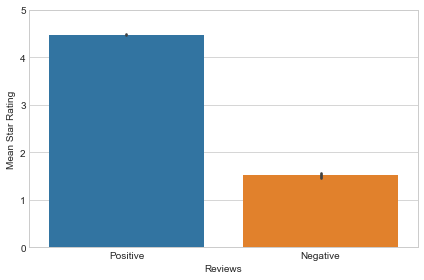

In [92]:
# bar plot of positive and negative reviews and mean star rating
sns.barplot(x=to.positive_negative, y=to.stars_y)
plt.xlabel("Reviews")
plt.ylabel("Mean Star Rating")
plt.ylim(0,5)
plt.tight_layout()

plt.savefig("reviews_rating_barplot.png", dpi=900);

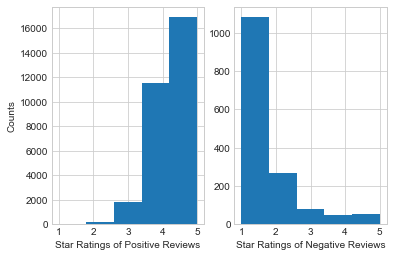

In [93]:
# histogram of star ratings of positive and negative reviews
positive_stars = to[to.positive_negative=="Positive"].stars_y
negative_stars = to[to.positive_negative=="Negative"].stars_y

plt.subplot(1,2,1)
plt.hist(positive_stars, bins=5)
plt.xlabel("Star Ratings of Positive Reviews")
plt.ylabel("Counts")

plt.subplot(1,2,2)
plt.hist(negative_stars, bins=5)
plt.xlabel("Star Ratings of Negative Reviews")

plt.savefig("positive_negative_stars_histograms.png", dpi=900);

In [94]:
to.positive_negative.value_counts()

Positive    30528
Negative     1531
Name: positive_negative, dtype: int64

### Wordcloud Visualizations

In [30]:
# helper function to create word clouds
def create_wordcloud(text_list, mask, filename, n_words=100):
    wordcloud = WordCloud(background_color="white", stopwords=STOPWORDS, mask=mask, max_font_size=100, max_words=n_words, width=600, height=600)
    wordcloud.generate(" ".join(text_list))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    if filename:
        plt.savefig(filename, dpi=600)
    plt.show();

In [31]:
# load masks for wordclouds
thumbsup_mask = imread('thumbsup2.001.png')
thumbsdown_mask = imread('thumbsdown.001.png')

### Latent Topics in Positive Reviews

I explored a few different latent topic modeling methods (i.e., latent semantic analysis (LSA), latent Dirichlet allocation (LDA), and non-negative matrix factorization (NMF)). After examining the latent topics, NMF looked like the better choice. Including bigrams in the analysis didn't add relevant information.

In [14]:
# vectorize bag positive reviews using tfidf
tfidf = TfidfVectorizer(min_df=0.0001)
X_positive = tfidf.fit_transform(positive_reviews)
positive_word_list = tfidf.get_feature_names()
len(positive_word_list)

5990

In [15]:
X_positive.shape

(30528, 5990)

#### Dimensionality Reduction

In [16]:
# identify latent topics using non-negative matrix factorization (NMF)
nmf = NMF(n_components=6, random_state=111, alpha=.1, l1_ratio=.5, init='nndsvd')
X_positive_reduced = nmf.fit_transform(X_positive)
components = nmf.components_
print(components)

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.10186283 ...,  0.          0.          0.00926144]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.00872517 ...,  0.          0.          0.        ]
 [ 0.          0.          0.01287906 ...,  0.          0.          0.        ]]


In [17]:
X_positive_reduced.shape

(30528, 6)

In [18]:
# examine the top 20 words associated with each latent topic
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(positive_word_list, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:20],"\n")

topic 0
[('great', 8.719874933133358), ('food', 4.003505067603335), ('service', 3.5520760004602039), ('atmosphere', 1.9102342981682947), ('excellent', 1.3097768422354452), ('place', 1.2979306662863113), ('price', 1.2292964504878729), ('drink', 0.98643612549027482), ('beer', 0.87494365140410191), ('fantastic', 0.82684094827326171), ('selection', 0.76520016554464942), ('spot', 0.75975875274161597), ('awesome', 0.67607025437271884), ('patio', 0.66065473655946871), ('night', 0.63499280458329677), ('experience', 0.62196432094212395), ('wine', 0.54869553839936414), ('menu', 0.53201794219226994), ('dinner', 0.51240459768830571), ('time', 0.50720168777072461)] 

topic 1
[('good', 9.4335745064262557), ('price', 2.1446252424029821), ('pretty', 2.018501083234185), ('food', 1.8468080434249214), ('service', 1.3332505146837634), ('place', 1.174413042200902), ('ve', 1.0779370899833367), ('nice', 0.94136111163748104), ('like', 0.81666133056283796), ('portion', 0.78224121856794449), ('quality', 0.59490

### Clustering

I explored a few different unsupervised clustering methods (i.e., K-means, agglomerative clustering, and DBSCAN). After examining the clusters, K-means produced the most well-distributed clusters.

In [19]:
X_positive_reduced.shape

(30528, 6)

In [39]:
# try out a range of cluster sizes to find the one with the best inertia and silhouette scores
ns = np.arange(2, 20, 1)
inertias = []
silhouettes = []

for n in ns:
    kmeans = KMeans(n_clusters=n, init="k-means++", random_state=123)
    kmeans.fit(X_positive_reduced)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    # only a sample was used to calculate silhouette score because of memory errors
    silhouettes.append(silhouette_score(X_positive_reduced, labels, metric='euclidean', sample_size=5000))
    

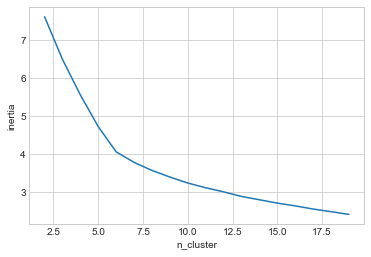

In [40]:
# plot the inertia scores and look for the kink in the curve
plt.plot(ns, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

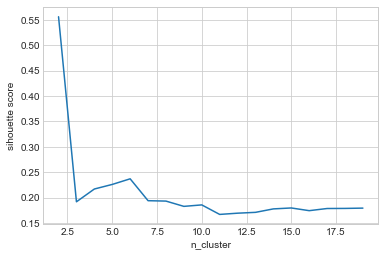

In [41]:
# plot the silhouettte scores
plt.plot(ns, silhouettes)
plt.xlabel('n_cluster')
plt.ylabel('sihouette score');

In [20]:
# based on inertia and silhouette scores, a cluster size of 6 was selected
kmeans = KMeans(n_clusters=6, init="k-means++", random_state=824)
kmeans.fit(X_positive_reduced)
positive_labels = kmeans.labels_
print("Inertia score: {}".format(kmeans.inertia_))
print("Silhouette score: {}".format(silhouette_score(X_positive_reduced, positive_labels, metric='euclidean', sample_size=5000, random_state=824))) #memory error

Inertia score: 4.0629909904310475
Silhouette score: 0.23843834395690375


In [21]:
# examine the number of reviews for in each cluster
for cluster in range(len(set(positive_labels))):
    print("Cluster {} has {} reviews.".format(cluster, sum(positive_labels==cluster)))

Cluster 0 has 5666 reviews.
Cluster 1 has 3974 reviews.
Cluster 2 has 10410 reviews.
Cluster 3 has 1222 reviews.
Cluster 4 has 3634 reviews.
Cluster 5 has 5622 reviews.


### Visualization of Clusters

In [13]:
df_positive_reduced = pd.DataFrame(X_positive_reduced)
df_positive_reduced['positive_reviews'] = positive_reviews
df_positive_reduced['positive_labels'] = positive_labels

In [45]:
positive_complete_text = to[to.combined_nltk > 0.3]["text"].reset_index()

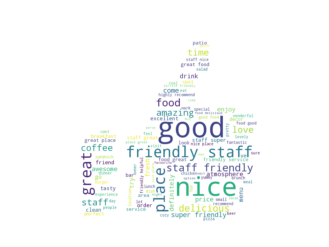

In [46]:
# visualize positive review cluster 1
positive_cluster1 = list(df_positive_reduced[df_positive_reduced.positive_labels==1].positive_reviews)
create_wordcloud(positive_cluster1, thumbsup_mask, "positive_cluster1.png")

In [47]:
# example of a review in cluster 1
print("Original Review: {}".format(positive_complete_text.iloc[17826,:].text))

Original Review: Great place for some spicy coconut curries.  Can't say if it is authentic Cambodian, but it is delicious.  It is small and not well decorated, but the food is terrific and the staff pleasant and helpful.  Very reasonable prices.


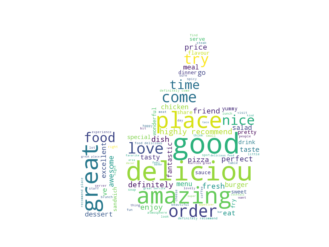

In [48]:
# visualize positive review cluster 2
positive_cluster2 = list(df_positive_reduced[df_positive_reduced.positive_labels==2].positive_reviews)
create_wordcloud(positive_cluster2, thumbsup_mask, "positive_cluster2.png")

In [58]:
# example of a review in cluster 2
print("Original Review: {}".format(positive_complete_text.iloc[9502,:].text))

Original Review: Excellent fresh food, well priced and amazing service. I had the gyro sandwich, best I've had to date. The dinner platter even comes with Dessert!


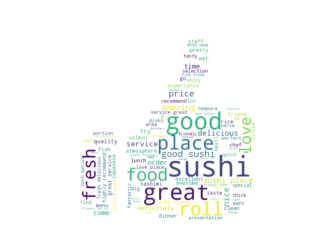

In [49]:
# visualize positive review cluster 3
positive_cluster3 = list(df_positive_reduced[df_positive_reduced.positive_labels==3].positive_reviews)
create_wordcloud(positive_cluster3, thumbsup_mask, "positive_cluster3.png")

In [38]:
# example of a review in cluster 3
print("Original Review: {}".format(positive_complete_text.iloc[964,:].text))

Original Review: Ordered take out last week and it was AMAZING! Rolls made fresh in front of you. I had the avocado roll and the spicy crab roll, both delicious. Staff were very friendly. Would definitely go. Glad I found this gem.


In [18]:
X_positive_reduced.shape

(30528, 6)

In [22]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=824)
tsne_positive = tsne.fit_transform(X_positive_reduced)

In [23]:
df_tsne_positive = pd.DataFrame(tsne_positive, columns=["tsne_x", "tsne_y"])
df_tsne_positive.shape

(30528, 2)

In [28]:
df_tsne_positive["Cluster"] = positive_labels
df_tsne_positive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30528 entries, 0 to 30527
Data columns (total 4 columns):
tsne_x             30528 non-null float32
tsne_y             30528 non-null float32
positive_labels    30528 non-null int32
Cluster            30528 non-null int32
dtypes: float32(2), int32(2)
memory usage: 477.1 KB


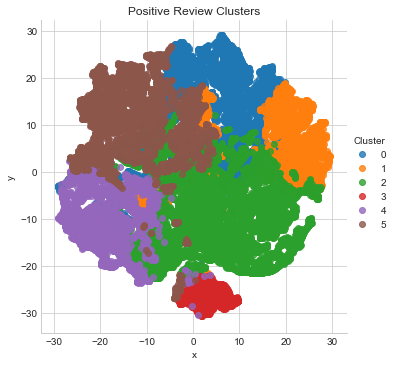

In [30]:
# visualize the positive review clusters using t-SNE
tsne_positive = sns.lmplot("tsne_x", "tsne_y", data=df_tsne_positive, fit_reg=False, hue="Cluster")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Positive Review Clusters");

### Latent Topics in Negative Reviews

In [31]:
# vectorize bag positive reviews using tfidf
tfidf = TfidfVectorizer(min_df=0.005)
X = tfidf.fit_transform(negative_reviews)
negative_word_list = tfidf.get_feature_names()
len(negative_word_list)

562

In [32]:
x = list(X)
len(x)

1531

#### Dimensionality Reduction

In [33]:
# identify latent topics using non-negative matrix factorization (NMF)
nmf = NMF(n_components=6, random_state=111, alpha=.1, l1_ratio=.5, init='nndsvd')
X_negative_reduced = nmf.fit_transform(X)
components = nmf.components_
print(components)

[[ 0.02925495  0.02822097  0.02222956 ...,  0.          0.01275363
   0.04997379]
 [ 0.          0.1120912   0.01402064 ...,  0.02103331  0.          0.        ]
 [ 0.          0.04835934  0.01403202 ...,  0.          0.          0.        ]
 [ 0.          0.11331515  0.05941708 ...,  0.          0.00724153
   0.0029688 ]
 [ 0.          0.02178262  0.         ...,  0.          0.          0.00051007]
 [ 0.          0.03765172  0.0442465  ...,  0.          0.          0.        ]]


In [34]:
X_negative_reduced.shape

(1531, 6)

In [35]:
# examine the top 20 words associated with each latent topic
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(negative_word_list, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:20],"\n")

topic 0
[('bad', 3.4072097185251944), ('service', 1.005868361455591), ('ve', 0.59344657062290618), ('experience', 0.44230631427802847), ('food', 0.31021201341066651), ('don', 0.2593413320212361), ('customer', 0.25643986941778601), ('eat', 0.24859679779565491), ('sushi', 0.24542929534779342), ('waitress', 0.23815531529450482), ('come', 0.20640680304783082), ('taste', 0.18819659289822585), ('review', 0.18173445941600003), ('go', 0.17329573660177142), ('attitude', 0.16540009926110333), ('smell', 0.16032552874090822), ('suck', 0.15126762484746203), ('recommend', 0.14927306142303426), ('drink', 0.14037086745547087), ('fresh', 0.13748026705235103)] 

topic 1
[('rude', 2.3005395413152838), ('staff', 1.4745502786592555), ('service', 0.6475154887639214), ('customer', 0.58654194924477032), ('extremely', 0.49432271474001299), ('waitress', 0.40877767789733183), ('waiter', 0.38758929528223135), ('wait', 0.30553089218149304), ('time', 0.28912147787871423), ('manager', 0.27526977478288372), ('awful',

### Clustering

In [36]:
# try out a range of cluster sizes to find the one with the best inertia and silhouette scores
ns = np.arange(2, 20, 1)
inertias = []
Sil_coefs = []
for n in ns:
    kmeans = KMeans(n_clusters=n, init="k-means++", random_state=81617).fit(X_negative_reduced)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    Sil_coefs.append(silhouette_score(X_negative_reduced, labels, metric='euclidean'))

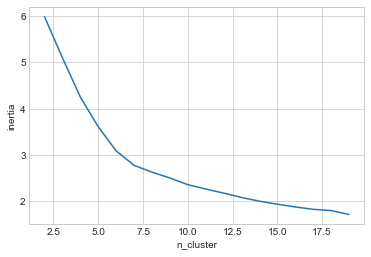

In [56]:
# plot the inertia scores and look for the kink in the curve
plt.plot(ns, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

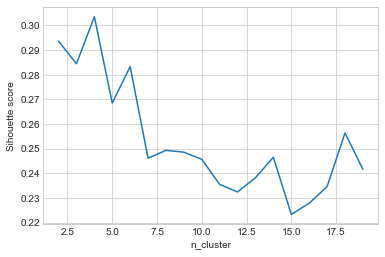

In [57]:
# plot the silhouette scores
plt.plot(ns, Sil_coefs)
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [37]:
# based on inertia and silhouette scores, a cluster size of 6 was selected
kmeans = KMeans(n_clusters=6, init="k-means++", random_state=824)
kmeans.fit(X_negative_reduced)
negative_labels = kmeans.labels_
print("Inertia score: {}".format(kmeans.inertia_))
print("Silhouette score: {}".format(silhouette_score(X_negative_reduced,negative_labels, metric='euclidean', sample_size=5000, random_state=824))) #memory error

Inertia score: 3.091811524106161
Silhouette score: 0.2829168396672965


In [38]:
# examine the number of reviews for in each cluster
for cluster in range(len(set(negative_labels))):
    print("Cluster {} has {} reviews.".format(cluster, sum(negative_labels==cluster)))

Cluster 0 has 625 reviews.
Cluster 1 has 165 reviews.
Cluster 2 has 163 reviews.
Cluster 3 has 211 reviews.
Cluster 4 has 247 reviews.
Cluster 5 has 120 reviews.


### Visualization of Clusters

In [39]:
df_negative_reduced = pd.DataFrame(X_negative_reduced)
df_negative_reduced['negative_reviews'] = negative_reviews
df_negative_reduced['negative_labels'] = negative_labels

In [68]:
df_negative_reduced.head()

,0,1,2,3,4,5,negative_reviews,negative_labels
0,0.000000,0.007996,0.019215,0.000000,0.000286,0.000000,dead store wait work care understand,0
1,0.007928,0.012055,0.000000,0.064665,0.060451,0.010090,din yelp review extremely disappoint food serv...,3
2,0.033247,0.000000,0.000000,0.019607,0.000000,0.000000,zero star possible bad korean food super expen...,0
3,0.045154,0.061108,0.000000,0.051974,0.000000,0.001457,food good service bad guy talk pay bill rude i...,2
4,0.000000,0.000000,0.000000,0.000000,0.081495,0.000000,place sadly close location near warden steele ...,3


In [61]:
negative_complete_text = to[to.combined_nltk < -0.2]["text"].reset_index()

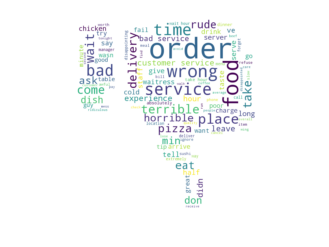

In [64]:
# visualize positive review cluster 1
negative_cluster0 = list(df_negative_reduced[df_negative_reduced.negative_labels==1].negative_reviews)
create_wordcloud(negative_cluster0, thumbsdown_mask, "negative_cluster0.png", n_words=100)

In [100]:
# example of a review in cluster 1
print("Original Review: {}".format(negative_complete_text.iloc[248,:].text))

Original Review: Wrong order times 3. Slow. Cheap. Bad presentation. Tastes bland. Where do I begin? I miss their old location and management on yonge street. That was a tightly run ship.


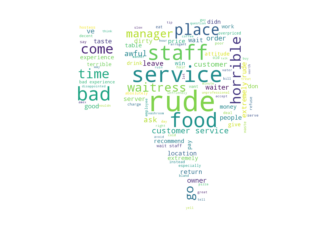

In [67]:
# visualize positive review cluster 2
negative_cluster2 = list(df_negative_reduced[df_negative_reduced.negative_labels==2].negative_reviews)
create_wordcloud(negative_cluster2, thumbsdown_mask, "negative_cluster2.png", n_words=100)

In [102]:
# example of a review in cluster 2
print("Original Review: {}".format(negative_complete_text.iloc[1266,:].text))

Original Review: lame service. rude/bossy waiter, disorganized service and over priced beer. Do not recommend.


In [40]:
X_negative_reduced.shape

(1531, 6)

In [91]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=500, random_state=824)
tsne_negative = tsne.fit_transform(X_negative_reduced)

In [92]:
df_tsne_negative = pd.DataFrame(tsne_negative, columns=["tsne_x", "tsne_y"])
df_tsne_negative.shape

(1531, 2)

In [93]:
df_tsne_negative["Cluster"] = negative_labels
df_tsne_negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531 entries, 0 to 1530
Data columns (total 3 columns):
tsne_x     1531 non-null float32
tsne_y     1531 non-null float32
Cluster    1531 non-null int32
dtypes: float32(2), int32(1)
memory usage: 18.0 KB


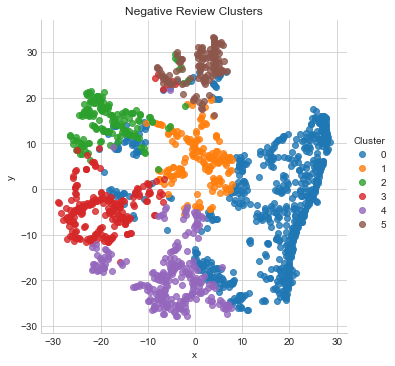

In [94]:
# visualize the negative review clusters using t-SNE
tsne_negative = sns.lmplot("tsne_x", "tsne_y", data=df_tsne_negative, fit_reg=False, hue="Cluster")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Negative Review Clusters");

### Summary

Toronto restaurant diners valued quality of food and service the most. In their reviews, they typically complimented or complained about these two topics. To a lesser extent, diners commented about atmosphere and price. For this project, I didn't differentiate between different types of restaurants, such as fast food, casual dining, and fine dining. I expect that diners of different types of restaurants would value atmosphere and price to different degrees. Diners at fast food may be more forgiving about a lackluster atmosphere, whereas diners at fine dining restaurants may be more forgiving about the higher prices.

Overall, there a lot more positive reviews than negative reviews (almost 20 times more). There can be multiple reasons for this. In general, restaurant diners may have more positive than negative experiences; reviewers may be more inclined to post a review if they had a positive experience; or Yelp reviewers are a specific type of people (not representative of all restaurant diners), and they tend to have positive experiences or write positive reviews. These analyses were conducted on Toronto restaurant Yelp reviews and the results from these analyses may also not be applicable to restaurant reviews from other large cities.

### Future Steps

In the future, I would like to expand the cities included in the analyses and compare if different cities review similar topics in their restaurant reviews. I would also like to categorize restaurants based on type, and examine how restaurant reviews and expectations can differ within and between these types.